# Imports, pip e variáveis globais

In [96]:
# Maneira elegante de instalar os pacotes para que não demore nas execuções seguintes
if 'package_installed_kv_pair' not in globals():
    # Se não estiver definida, inicializa como um dicionário vazio
    package_installed_kv_pair = {}

# Lista de pacotes a serem verificados
packages = ['qiskit-aer', 'qiskit', 'qiskit-ibm-runtime', 'qiskit_aer', 'pylatexenc', 'tweedledum', 'qiskit-algorithms', 'pdflatex', 'numpy', 'pillow']

# Verifica se cada pacote já está instalado
for package in packages:
    if package_installed_kv_pair.get(package) is None:
        package_installed_kv_pair[package] = True
        %pip install {package}


In [133]:
# Visualization
from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# BackEnd
from qiskit.providers.basic_provider import BasicProvider

# Circuit
from qiskit import QuantumRegister, QuantumCircuit, transpile, assemble
from qiskit.circuit.library import CCZGate, ZGate
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import PhaseOracle
from qiskit.circuit import Qubit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit.circuit.library import C3XGate
from qiskit.circuit.library import CXGate
from qiskit.circuit.library import CCXGate


# Utils
from qiskit.quantum_info import Statevector
import numpy as np
import pandas as pd
import itertools
import pdflatex
import statistics


In [98]:
# Global
CLAUSES_QTY = 6 # 4-SAT
QUBIT_QTY = CLAUSES_QTY

EXPRESSION = "(~A | ~B | ~C) & (A | ~B | C) & (A | B | ~C)"

# EXPERIMENTAL
USE_RANDOM_EXPRESSION = False

# Utilidade

# Criação do Oráculo que representa a nossa expressão

In [ ]:
def CreateOracle():
  qubit_qtd = clauses_qtd = 3

  qreg_q_literal = QuantumRegister(qubit_qtd, 'q')
  qreg_q_ancilla = QuantumRegister(clauses_qtd + 1, 'a')
  creg_c = ClassicalRegister(qubit_qtd, 'c')
  qc = QuantumCircuit(qreg_q_literal, qreg_q_ancilla, creg_c)

  qc.h(6)
  qc.z(6)
  qc.barrier()
  # (~A | ~B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [0,1,2,3])
  # (A | ~B | C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,2,1,4])
  # (A | B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,1,2,5])

  # Conjuncao
  qc.barrier()
  qc.x(qreg_q_ancilla[0])
  qc.x(qreg_q_ancilla[1])
  qc.x(qreg_q_ancilla[2])
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [3,4,5,6])
  qc.x(qreg_q_ancilla[0])
  qc.x(qreg_q_ancilla[1])
  qc.x(qreg_q_ancilla[2])
  qc.barrier()

  # Simetria (A | B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,1,2,5])

  # Simetria  (A | ~B | C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,2,1,4])

  # Simetria  (~A | ~B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [0,1,2,3])

  # Barreira
  qc.barrier()

  return qc

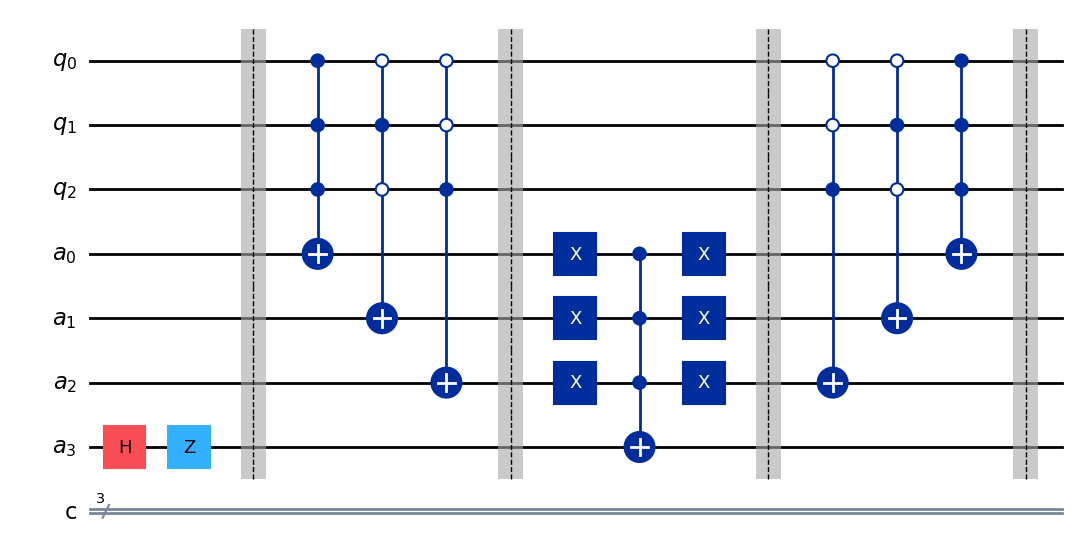

In [146]:
oracle = CreateOracle()
oracle.draw("mpl")

# Diagonal
Baseado na implementação de Giancarlo
* https://github.com/giangamberi/
Estudo-de-algoritmos-quanticos-e-suas-implementacoes/blob/main/EAQSI.ipynb

* https://dspace.mackenzie.br/items/071a8df2-1a8f-45c2-ab22-49749d06479b

In [101]:
def CreateDiagonalSequence(number, qubits):
    diagonalSize = pow(2,qubits)
    if (diagonalSize < number - 1): return -1
    aux = np.ones(diagonalSize, dtype=int)
    aux[number] = -1
    return aux

def GetDiagonal():
  qubit_qtd = 3 # Quantidade de literais que serão medidas após a execução do circuito
  groverDiagonal = list(CreateDiagonalSequence(0, qubit_qtd))
  return Diagonal(groverDiagonal) # Instancia da diagonal disponibilizada pelo qisikit

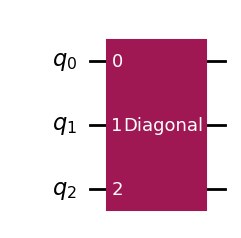

In [102]:
diagonal = GetDiagonal()
diagonal.draw('mpl')

# Concatenando oráculo com operador de grover
(Grover Operator + Oracle)

In [103]:
def ApplyGrover(oracle):
  num_qubits = 7
  qr = QuantumRegister(num_qubits, name="State")
  qc = QuantumCircuit(qr, name = "Grover Operator")
  qubits = [0,1,2,3,4,5,6]
  qc.compose(oracle, qubits, inplace=True) #Adiciona a oráculo já criada no início do circuito

  # D = WRW
  # Aplica Hadamart Para cada qubit (W)
  qc.h(0)
  qc.h(1)
  qc.h(2)

  #Aplica a diagonal (R)
  qc.compose(
      GetDiagonal(),qubits=[0,1,2], inplace=True
  )
  # Aplica Hadamart Para cada qubit (W)
  qc.h(0)
  qc.h(1)
  qc.h(2)

  return qc

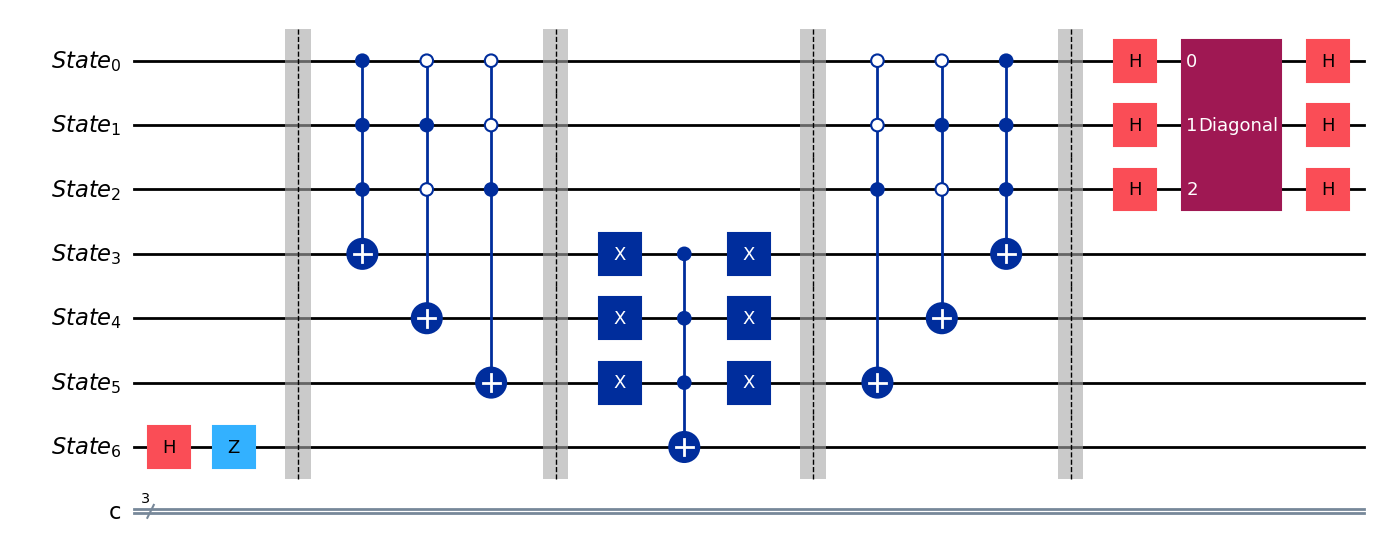

In [139]:
oracle = CreateOracle()
merged_two = ApplyGrover(oracle)
merged_two.draw("mpl")

# Amplificação com hadamart
(Hadamart > Grover Operator)

In [105]:
def AmplifyWithHadamart(qc, oracle):
  qc.h(0)
  qc.h(1)
  qc.h(2)

  qc.compose(oracle, inplace=True)
  return qc

# Montagem do circuito

Hadamart -> Grover and Oracle -> Measure

In [ ]:
# Using Our Grover Operator
qubit_qtd = clauses_qtd = 3

qreg_q_literal = QuantumRegister(qubit_qtd, 'q')
qreg_q_ancilla = QuantumRegister(clauses_qtd + 1, 'a')
creg_c = ClassicalRegister(qubit_qtd, 'c')

sat_problem = QuantumCircuit(qreg_q_literal, qreg_q_ancilla, creg_c, name=f"Circuit for our 3-sat problem")
oracle = CreateOracle(sat_problem)
groverCircuit = ApplyGrover(oracle)
AmplifyWithHadamart(sat_problem, groverCircuit)


sat_problem.barrier()

sat_problem.measure([0], [0])
sat_problem.measure([1], [1])
sat_problem.measure([2], [2])


sat_problem.draw("latex")

UnboundLocalError: local variable 'qreg_q_ancilla' referenced before assignment

In [107]:
print(sat_problem.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{H}} & \qw \barrier[0em]{6} & \qw & \ctrl{1} & \ctrlo{1} & \ctrlo{1} \barrier[0em]{6} & \qw & \qw & \qw & \qw \barrier[0em]{6} & \qw & \ctrlo{1} & \ctrlo{1} & \ctrl{1} \barrier[0em]{6} & \qw & \gate{\mathrm{H}} & \multigate{2}{\mathrm{Diagonal}}_<<<{0} & \gate{\mathrm{H}} \barrier[0em]{6} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{H}} & \qw & \qw & \ctrl{1} & \ctrl{1} & \ctrlo{1} & \qw & \qw & \qw & \qw & \qw & \ctrlo{1} & \ctrl{1} & \ctrl{1} & \qw & \gate{\mathrm{H}} & \ghost{\mathrm{Diagonal}}_<<<{1} & \gate{\mathrm{H}} & \qw & \qw & \meter & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{H}} & \qw & \qw & \ctrl{1} & \ctrlo{2} & \ctrl{3} & \qw & \qw & \qw & \qw & \q

# Diagrama do circuito

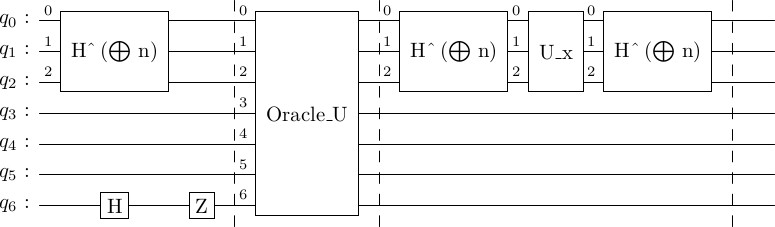

In [108]:
# Using Our Grover Operator
# Please install a tex distro having qcircuit package installed before running this piece of code

def GetDifuserAsGate():
  qr = QuantumRegister(3, name="State")
  qc = QuantumCircuit(qr)
  qc.name = "U_x"
  
  #Aplica a diagonal
  qc.compose(
      GetDiagonal(),qubits=[0,1,2], inplace=True
  )
  return qc

def GetHadamartAsGate():
    qreg_q = QuantumRegister(3, 'q')
    qc = QuantumCircuit(qreg_q, name = "H{^ (\\bigoplus n)}")
    qc.h(0)
    qc.h(1)
    qc.h(2)

    # qc.compose(oracle, inplace=True)
    return qc
  
def GetOracleAsGate():
  qreg_q = QuantumRegister(7, 'q')
  qc = QuantumCircuit(qreg_q, name = "Oracle_U")

  qc.h(6)
  qc.z(6)
  # (~A | ~B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [0,1,2,3])
  # (A | ~B | C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,2,1,4])
  # (A | B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,1,2,5])

  # Meio
  qc.x(qreg_q[3])
  qc.x(qreg_q[4])
  qc.x(qreg_q[5])
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [3,4,5,6])
  qc.x(qreg_q[3])
  qc.x(qreg_q[4])
  qc.x(qreg_q[5])

  # Espelho (A | B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,1,2,5])

  # Espelho  (A | ~B | C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='00'), [0,2,1,4])

  # Espelho  (~A | ~B | ~C)
  qc.append(CXGate().control(num_ctrl_qubits=2, ctrl_state='11'), [0,1,2,3])

  # Barreira
  return qc.to_gate()

diagram = QuantumCircuit(7, name=f"Diagram for our 3-sat problem")

# HAdamart Zed
diagram.h(6)
diagram.z(6)

#Hadamart
hadamartDiagram = GetHadamartAsGate()
diagram.append(hadamartDiagram, range(3))
diagram.barrier()

# Oracle
oracleDiagram = GetOracleAsGate()
diagram.append(oracleDiagram, range(7))
diagram.barrier()

#Hadamart
diagram.append(hadamartDiagram, range(3))

#Difuser
difuserDiagram = GetDifuserAsGate()
diagram.append(difuserDiagram, range(3))

#Hadamart
diagram.append(hadamartDiagram, range(3))
diagram.barrier()




diagram.draw("latex")


In [109]:
print(diagram.draw("latex_source"))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{2}{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{0} & \qw \barrier[0em]{6} & \qw & \multigate{6}{\mathrm{Oracle\_U}}_<<<{0} \barrier[0em]{6} & \qw & \multigate{2}{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{0} & \multigate{2}{\mathrm{U\_x}}_<<<{0} & \multigate{2}{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{0} \barrier[0em]{6} & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{1} & \qw & \qw & \ghost{\mathrm{Oracle\_U}}_<<<{1} & \qw & \ghost{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{1} & \ghost{\mathrm{U\_x}}_<<<{1} & \ghost{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{1} & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \ghost{\mathrm{H{\string^\,(\bigoplus\,n)}}}_<<<{2} & \qw & \qw & \gho

# Execução do circuito

In [110]:
backend = BasicProvider().get_backend("basic_simulator")

# Execução do circuito obtido
transpiled = transpile(sat_problem, backend)
qobj = assemble(transpiled)
result = backend.run(transpiled).result()
count = result.get_counts()

# Apresentação dos resultados obtidos

{'100': 304, '010': 267, '111': 287, '001': 27, '000': 30, '101': 35, '110': 39, '011': 35}


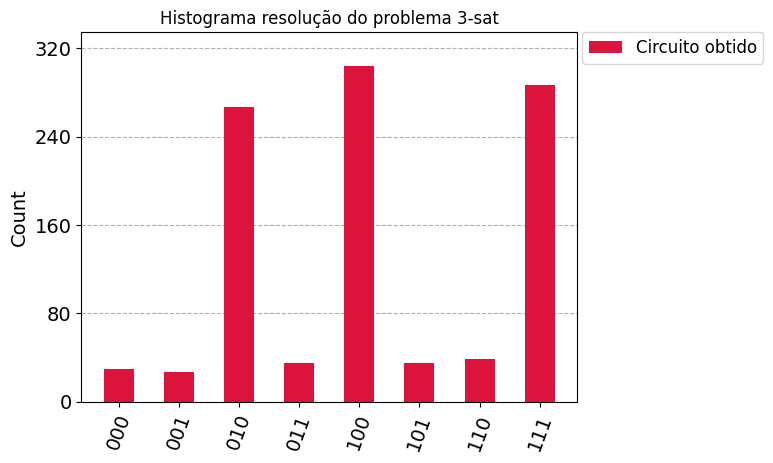

In [111]:
# Plot
fig, ax = plt.subplots()
legend = ["Circuito obtido"]
title = f"Histograma resolução do problema 3-sat"
plot_histogram([count], color='crimson', title=title, legend=legend, bar_labels=False, ax=ax)

print(count)
plt.show()

# Circuito feito usando abstrações do qiskit

Para fins de comparação, foi feito a resolução do mesmo problema, porém a abstração disponibilizada no toolkit da ibm, conforme o tutorial deste link:
https://qiskit-community.github.io/qiskit-algorithms/tutorials/07_grover_examples.html

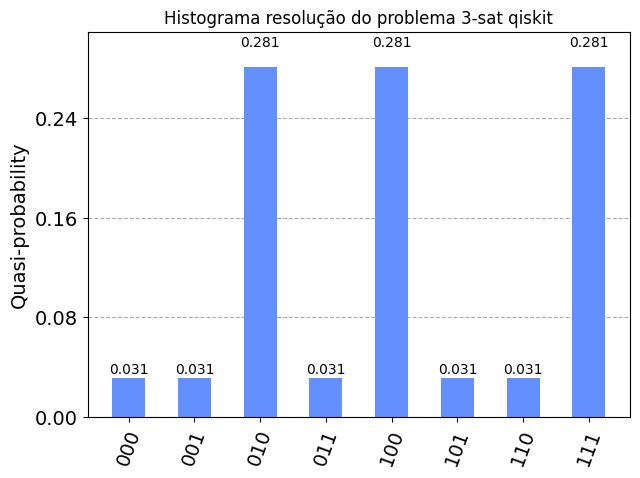

In [112]:
from qiskit.circuit.library import GroverOperator
from qiskit.primitives import BackendSampler
from qiskit.primitives import Sampler
from qiskit_algorithms import Grover, AmplificationProblem
from qiskit.result.counts import Counts

qiskit_oracle = PhaseOracle(EXPRESSION)


sampler = Sampler()

qiskit_problem = AmplificationProblem(qiskit_oracle)
qiskit_grover = Grover(sampler = sampler, iterations=1)
qiskit_result = qiskit_grover.amplify(qiskit_problem)


# Plot
plot_histogram(qiskit_result.circuit_results, title="Histograma resolução do problema 3-sat qiskit")

# Comparação e Implementação brute force

In [113]:
def generate_truth_table(expression):
    variables = sorted(set([char for char in expression if char.isalpha()]))
    expression = expression.replace("~", " not ")
    expression = expression.replace("&", " and ")
    expression = expression.replace("|", " or ")
    rows = []
    for combination in itertools.product([False, True], repeat=len(variables)):
        variables_dict = {}
        for i in range(len(variables)):
          variables_dict[variables[i]] = combination[i]
        result = eval(expression, variables_dict)
        row_values = list(combination) + [result]
        rows.append(row_values)

    columns = variables + [expression]
    truth_table = pd.DataFrame(rows, columns=columns)
    truth_table = truth_table.rename(columns={truth_table.columns[-1]: 'Result'})
    return truth_table

# Exemplo de uso:
brute_force_truth_table = generate_truth_table(EXPRESSION)
print(brute_force_truth_table)

       A      B      C  Result
0  False  False  False    True
1  False  False   True   False
2  False   True  False   False
3  False   True   True    True
4   True  False  False    True
5   True  False   True    True
6   True   True  False    True
7   True   True   True   False


In [114]:
# Conversão de cada linha para uma lista de strings
def GetRowValuesAsList(df):
  string_list = []
  for index, row in df.iterrows():  # Excluindo a última linha
      string_values = ['1' if value else '0' for value in row[:-1]]  # Convertendo valores booleanos em strings 'True' ou 'False'
      string_list.append(''.join(string_values))  # Unindo os valores em uma única string e adicionando à lista
  string_list.sort()
  return string_list

# Captura dos dados que resultam em true || false no data frame obtido
def GetBruteForceResults(df):
  sat_brute_force = (brute_force_truth_table[brute_force_truth_table['Result'] == True])
  unsat_brute_force = (brute_force_truth_table[brute_force_truth_table['Result'] == False])

  sat_brute_force = GetRowValuesAsList(sat_brute_force)
  unsat_brute_force = GetRowValuesAsList(unsat_brute_force)
  return { "SAT" : sat_brute_force , "UNSAT" : unsat_brute_force}

brute_force_results = GetBruteForceResults(generate_truth_table(EXPRESSION))
print("SOLUÇÃO BRUTE FORCE: ", brute_force_results,)

SOLUÇÃO BRUTE FORCE:  {'SAT': ['000', '011', '100', '101', '110'], 'UNSAT': ['001', '010', '111']}


In [115]:
# Resultado do nosso circuito
def GetResults():
  median = statistics.mean([value for _, value in count.items()])
  results_sat = [key for key, value in count.items() if value >= median]
  results_unsat =  [key for key, _ in count.items() if key not in results_sat]

  results_sat = [key[::-1] for key in results_sat]
  results_unsat = [key[::-1] for key in results_unsat]

  results_sat.sort()
  results_unsat.sort()
  return { "SAT" : results_sat , "UNSAT" : results_unsat}

results = GetResults()
print("NOSSA SOLUÇÃO: ", results)

NOSSA SOLUÇÃO:  {'SAT': ['001', '010', '111'], 'UNSAT': ['000', '011', '100', '101', '110']}


In [116]:
brute_force_results = GetBruteForceResults(generate_truth_table(EXPRESSION))
print("FORÇA BRUTA: \t", brute_force_results)

shouldIterate = False
results = GetResults()
print("NOSSA SOLUÇÃO: \t", results)
if (results["SAT"] == brute_force_results["UNSAT"]):
    print("Resultados obtidos de satisfação são iguais aos obtidos de NÃO SATISFAÇÃO em força bruta")
elif (results["SAT"] == brute_force_results["SAT"]):
    print("Resultados obtidos de satisfação são iguais aos obtidos em força bruta")
else:
  print("Nenhum resultado bate com apenas uma iteração")
  shouldIterate = True

FORÇA BRUTA: 	 {'SAT': ['000', '011', '100', '101', '110'], 'UNSAT': ['001', '010', '111']}
NOSSA SOLUÇÃO: 	 {'SAT': ['001', '010', '111'], 'UNSAT': ['000', '011', '100', '101', '110']}
Resultados obtidos de satisfação são iguais aos obtidos de NÃO SATISFAÇÃO em força bruta
